# Regressione Logistica
Abbiamo la necessità di introdurre un nuovo modello per la classificazione binaria in quanto il Perceptron non converge mai se l'istanza non è separabile.

### DEF

Definiamo 
$$P=Pr(y=1|\bold{x})$$

la probabilità condizionata dell'evento $\bold{x}$ appartiene alla classe $1$.

### DEF  

Definiamo come rapporto probabilistico:

$$\text{odd}=\frac{p}{1-p}\in [ 0,+\infty )$$

### DEF

Definiamo la funzione:

$$\text{logit}(p)=ln(\frac{p}{1-p})\in (-\infty,+\infty)$$

La funzione manda i valori nel suo dominio a valori lungo l'intervallo di numeri reali, che possiamo utilizzare per esprimere una relazione lineare fra i valori delle caratteristiche e log-odds:

$$\text{logit}(P)=\bold{w}\cdot \bold{x}$$

Qui $P$ è la probabilità condizionata che un determinato campione appartenga alla classe $1$ sulla base delle sue caratteristiche $\bold{x}$.
Ora quello che ci interessa è prevedere la probabilità che un determinato campione appartenga a una determinata classe che è la forma inversa della funzione $\text{logit}$. Ovvero la funzione *sigmoide*:

$$e^{w\cdot x}=\frac{p}{1-p}\iff (1-p)e^{w\cdot x}=p \iff e^{w\cdot x}-pe^{w\cdot x}=p\iff p(1+e^{w\cdot x})=e^{w\cdot x}\iff p=\frac{e^{w\cdot x}}{1+e^{w\cdot x}}=\frac{1}{1+e^{-w\cdot x}}$$

Dunque 

$$\phi(z)=\frac{1}{1+e^{-z}}$$

Ove $z=\bold{w}\cdot \bold{x}$

Possiamo vedere che $\phi(z)$ si avvicina a $1$ se $z \rightarrow \infty$ e si avvicina a $0$ se $z \rightarrow -\infty$. Pertanto questa funzione manda valori reali in $[0,1]$, con un'intercettazione a $\phi(z)=0.5$. La funzione di attivazione nella regressione logistica è dunque la funzione sigmoide.

La probabilità prevista può essere poi convertita attraverso un quantizzatore:

$$\begin{cases}
    1 & \text{ se } \phi(z)\geq 0.5 \\
    0 & \text{ altrimenti }
\end{cases}$$



Deriviamo ora la funzione di costo. Per farlo definiamo la probabilità $L$ che vogliamo massimizzare.

$$L(\bold{w})=P(\bold{y}|\bold{x;w})=\prod_{i=1}^n P(y^{(i)}|x^{(i)};\bold{w})=\prod_{i=1}^n \phi(\bold{z}^{(i)}\bold{w})^{y^{(i)}}\cdot (1-\phi(\bold{z}^{(i)}\bold{w}))^{1-y^{(i)}}$$

E' molto più facile massimizzare il logaritmo di questa equazione:

$$l(\bold{w})=\log(L(\bold{w}))=\sum_{i=1}^n \log(\phi(z^{(i)}))+(1-y^{(i)})\log(1-\phi(z^{(i)}))$$

Ora possiamo utilizzare un algoritmo di ottimizzazione come quello a discesa del gradiente oppure proprio quest'ultimo a patto di riscrivere la funzione $l(\bold{w})$ come una funzione $J(\bold{w})$ che può essere minimizzata con la discesa del gradiente.

Dunque:

$$J(\bold{w})=-l(\bold{w})=\sum_{i=1}^n -\log(\phi(z^{(i)}))-(1-y^{(i)})\log(1-\phi(z^{(i)}))$$

Ora la regola di aggiornamento della discesa del gradiente è:
$$w \leftarrow w + \eta \nabla J(\bold{w})$$

e nel nostro caso è dunque 

$$w\leftarrow w+\eta X^T \cdot \bold{err}$$

In [2]:
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', '*', 'o', '^', 'v', '*')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Discesa del gradiente stocastica
La versione che conosciamo dell'algoritmo è detta *batch* in quanto calcola il gradiente tutto in una volta.

#### Criticità dell'algoritmo di discesa del gradiente:

L'aggiornamento dei pesi viene fatto nel seguente modo

```python
self.w_[1:] += self.eta * X.T.dot(errors)

# il che richiede l'intera matrice X che, nel caso questa sia molto grande, può rappresentare un problema di performance.
# Con la discesa del gradiente stocastica, i pesi vengono aggiornati uno alla volta nel seguente modo:

for xj, yj in zip(X, y):
                net_input = self.net_input(xj)
                output = self.activation(net_input)
                error = (yj - output)
                self.w_[1:] += self.eta * xj*error
```

Il che non richiede la presenza dell'intera matrice $X$ in memoria. Inoltre questo approccio permette anche l'addestramento on-line: il fitting può continuare con l'arrivo di altri dati di addestramento.

## Classe Regressione Logistica

In [3]:
class LogisticRegression(object):

    def __init__(self, eta=0.05, n_iter=50, random_state=1, fit="sfit", tol=1e-4):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.fit_method = fit
        self.last_cost = None
        self.tol = tol
        self.verbose = True
        
    def fit(self, X, y):
        if self.fit_method == 'sfit':
            return self.sfit(X, y)
        elif self.fit_method == 'bfit':
            return self.bfit(X, y)
        else:
            raise ValueError('I metodi accettati sono bfit e sfit')
        

    def bfit(self, X, y):

        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
   
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            epsilon = 1e-15
            output = np.clip(output, epsilon, 1 - epsilon)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # note that we compute the logistic `cost` now
            # instead of the sum of squared errors cost
            
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            if self.last_cost != None and abs(cost - self.last_cost) < self.tol:
                if self.verbose:
                    print('Num. iterations', i)
                break
            self.last_cost = cost
        
        return self
        
    def sfit(self, X, y):
      
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])


        for i in range(self.n_iter):
            cost = 0
            for xj, yj in zip(X, y):
                net_input = self.net_input(xj)
                output = self.activation(net_input)
                error = (yj - output)
                self.w_[1:] += self.eta * xj*error
                self.w_[0] += self.eta * error
            
                # note that we compute the logistic `cost` now
                # instead of the sum of squared errors cost
                
                cost += -yj*(np.log(output)) - ((1 - yj)*(np.log(1 - output)))
                if self.last_cost != None and abs(cost - self.last_cost) < self.tol:
                    if self.verbose:
                        print('Num. iterations', i)
                    return self
                
                self.last_cost = cost
        
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -700, 700)))
        #return 1. / (1. + np.exp(-z))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # equivalent to:
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

# Creazione Datframe

In [ ]:
s = os.path.join('dataset', 'iris.data')
df = pd.read_csv(s,
                 header=None,
                 encoding='utf-8')


# [0:50] iris-setosa
# [50:100] iris-versicolor
# [100:150] iris-virginica

y = df.iloc[50:, 4].values
y = np.where(y == 'Iris-versicolor', 1, 0)
# extract sepal length and petal length
X = df.iloc[50:, [0, 2]].values


# Esempi
### Versione Batch

Batch
 	Accuratezza: 0.9 
	Secondi: 0.04488348960876465


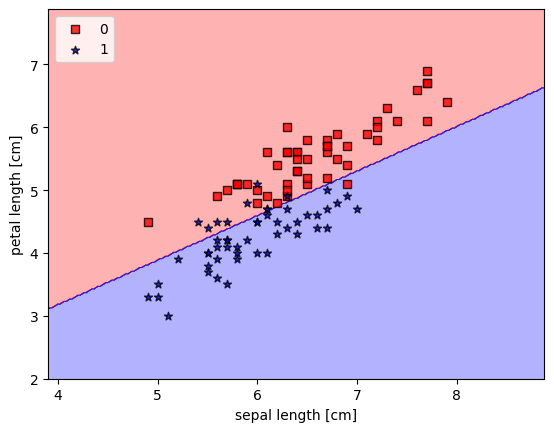

In [5]:
from time import time

start_time = time()
lgrg = LogisticRegression(n_iter=1000, eta=0.0001, random_state=1, fit='bfit').fit(X, y)
end_time = time()
accuracy = np.mean(lgrg.predict(X) == y)
print('Batch\n', '\tAccuratezza:', accuracy, '\n\tSecondi:', end_time-start_time)

plot_decision_regions(X, y, classifier=lgrg)

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

### Versione stocastica

Batch
 	Accuratezza: 0.9 
	Secondi: 1.1474838256835938


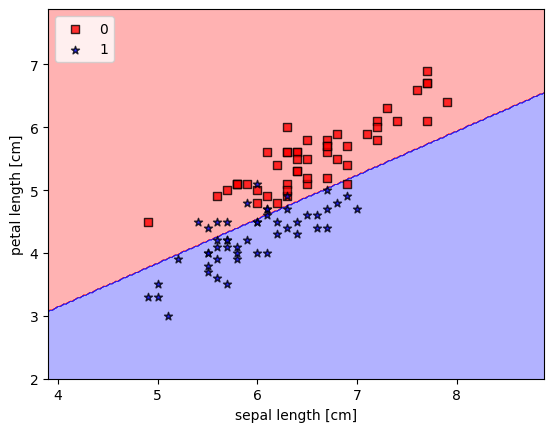

In [6]:
start_time = time()
lgrg = LogisticRegression(n_iter=1000, eta=0.0001, random_state=1, fit='sfit').fit(X, y)
end_time = time()
accuracy = np.mean(lgrg.predict(X) == y)
print('Batch\n', '\tAccuratezza:', accuracy, '\n\tSecondi:', end_time-start_time)

plot_decision_regions(X, y, classifier=lgrg)

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

# Standardizzazione
Livella i valori delle features portandole tutte sulla stessa scala, questo elimina il problema delle features troppo influenti in quanto su scale maggiori rispetto alle altre.

Sia $x$ un vettore delle features di media $\mu$ e deviazione standard $\sigma$ allora la z-score normalization

$$ x' = \frac{x-\mu}{\sigma} $$

definisce una nuova feature che ha media $0$ e deviazione standard $1$.

In [7]:
'''
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()
'''

# oppure
X_std = (X-X.mean(0))/X.std(0) # i valore 0 del parametri indica media e standard deviation sulle colonne

In [8]:
X_curr = X_std

start_time = time()
lgrg = LogisticRegression(n_iter=1000, eta=0.001, random_state=1, fit='bfit').fit(X_curr, y)
end_time = time()
accuracy = np.mean(lgrg.predict(X_curr) == y)
print('Batch, accuratezza', accuracy, 'Secondi:', end_time-start_time)

Batch, accuratezza 0.94 Secondi: 0.048931121826171875
